**In this notebook we are provided with daily historical sales [data](https://www.kaggle.com/c/competitive-data-science-predict-future-sales). The task is to forecast total sales for every product and store in the next month. Note that the list of shops and products slightly changes every month**

**For a full description of the files and data fields please refer to the data description using the link above.**

# 1. **Importing libraries**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. **Importing the data files we will use.**

In [2]:
data=pd.read_csv(r'../input/competitive-data-science-predict-future-sales/sales_train.csv') # The sales file

testd=pd.read_csv(r'../input/competitive-data-science-predict-future-sales/test.csv') # The test file

# 3. **Cleaning the data**

**Let's make a dataframe "grid" where we have every combination of shop_id, item_id and date_block_num.**

In [3]:
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']
grid = []
for i in data['date_block_num'].unique():
    cur_shops = data.loc[data['date_block_num'] == i, 'shop_id'].unique()
    cur_items = data.loc[data['date_block_num'] == i, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [i]])), dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

In [4]:
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


**Now we are going to group the dataframe "data" by the columns shop_id, item_id and date_block_num while having the sum of item_cnt_day and the mean of item_price**

In [5]:
data=data.groupby(by=['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day':'sum','item_price':np.mean}).reset_index()

**Let's merge the grouped 'data' with 'grid'**

In [6]:
data = pd.merge(grid,data,on=['date_block_num', 'shop_id', 'item_id'],how='left').fillna(0)

In [7]:
data.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_price
0,59,22154,0,1.0,999.0
1,59,2552,0,0.0,0.0
2,59,2554,0,0.0,0.0
3,59,2555,0,0.0,0.0
4,59,2564,0,0.0,0.0


**Now we will Hot encode the data and have the columns be the consecutive months and the rows be the unique combinations of item_id and shop_id.**

In [8]:
data=data.pivot_table(index=['item_id','shop_id'], columns='date_block_num',values='item_cnt_day',fill_value=0).reset_index()

In [9]:
data.head()

date_block_num,item_id,shop_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,6,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
testd.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


**Now we merge the test data into the cleaned data.**

In [11]:
df=pd.merge(testd, data, on=['item_id','shop_id'], how='left')

In [12]:
df=df.fillna(0)

In [13]:
df.head()

,ID,shop_id,item_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**let's drop the uninterpretable values.**

In [14]:
df = df.drop(labels=['ID', 'shop_id', 'item_id'], axis=1)

In [15]:
df.shape

(214200, 34)

**Now we will make a vector of zeros with 214200 unit length to add it to the data later.**

In [16]:
last_month=pd.DataFrame(np.zeros((214200, 1)),dtype='float',columns=[34])

In [17]:
df=pd.concat([df,last_month],axis=1)

In [18]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df.shape

(214200, 35)

**Now we will scale the data. We must transpose the data to make the combinations as features because scaling scale every feature's values individually and we need the scaling to work based on combinations insted of the data.**

In [20]:
df = df.transpose()

In [21]:
from sklearn.preprocessing import MinMaxScaler
ms=MinMaxScaler(feature_range=(-1,1))
df=ms.fit_transform(df)

**We transpose back to the original shape.**

In [22]:
df = df.transpose()

# 4. **Training the model.**

**Let's slice the training and validation data apart.**

**We will validate on a subset of the data.**

In [23]:
X_train=df[:,0:33]
y_train=df[:,33]
X_valid=df[10000:20000,0:33]
y_valid=df[10000:20000,33]
X_train=X_train.reshape(214200,33,1)
X_valid=X_valid.reshape(10000,33,1)

In [24]:
X_valid.shape

(10000, 33, 1)

In [25]:
X_train.shape

(214200, 33, 1)

**Let's build the model.**

In [26]:
from tensorflow.keras.layers import Dense,Dropout,LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

In [27]:
es=EarlyStopping(monitor='val_loss',patience=5)

In [28]:
import tensorflow as tf

**We will pass each row individually. **

In [29]:
model = Sequential()
model.add(LSTM(33,input_shape = (33,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam())

**Note : i use a notebook with gpu boosting.**

In [30]:
model.fit(X_train,y_train,epochs=1000,batch_size=3570,verbose=1,shuffle=False,callbacks=[es],validation_data=(X_valid,y_valid))

Train on 214200 samples, validate on 10000 samples
Epoch 1/1000
214200/214200 [==============================] - 6s 29us/sample - loss: 0.2954 - val_loss: 0.2535
Epoch 2/1000
214200/214200 [==============================] - 1s 3us/sample - loss: 0.2457 - val_loss: 0.2517
Epoch 3/1000
214200/214200 [==============================] - 1s 3us/sample - loss: 0.2446 - val_loss: 0.2506
Epoch 4/1000
214200/214200 [==============================] - 1s 3us/sample - loss: 0.2438 - val_loss: 0.2499
Epoch 5/1000
214200/214200 [==============================] - 1s 3us/sample - loss: 0.2432 - val_loss: 0.2494
Epoch 6/1000
214200/214200 [==============================] - 1s 3us/sample - loss: 0.2428 - val_loss: 0.2490
Epoch 7/1000
214200/214200 [==============================] - 1s 3us/sample - loss: 0.2425 - val_loss: 0.2488
Epoch 8/1000
214200/214200 [==============================] - 1s 3us/sample - loss: 0.2423 - val_loss: 0.2487
Epoch 9/1000
214200/214200 [==============================] - 1s 3us

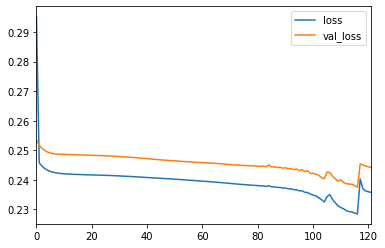

In [31]:
pd.DataFrame(model.history.history).plot()

**Not the best looking plot but it will do the job.**

5. **Making the predictions.**

In [32]:
X_test=df[:,1:34]

In [33]:
X_test.shape

(214200, 33)

In [34]:
X_test.dtype

dtype('float64')

In [35]:
predictions=model.predict(X_test.reshape(214200,33,1))

In [36]:
predictions.shape

(214200, 1)

In [37]:
predictions

array([[-0.68878716],
       [-0.9294877 ],
       [-0.5137304 ],
       ...,
       [-0.93469375],
       [-0.9294877 ],
       [-0.95401067]], dtype=float32)

In [38]:
predictions = predictions.astype('float64')

In [39]:
df.shape

(214200, 35)

In [40]:
full = np.concatenate((df[:,:-1],predictions),axis=1)

In [41]:
full.shape

(214200, 35)

**Let's Inverse-transform the data to what would it have been without scaling.**

In [42]:
full = ms.inverse_transform(full.transpose())

In [43]:
full = full.transpose()

In [44]:
predictions = full[:,-1:]

In [45]:
predictions

array([[0.46681926],
       [0.03525615],
       [0.72940439],
       ...,
       [0.06530625],
       [0.03525615],
       [0.068984  ]])

**The competition asked us in the description to clip the values between 0 and 20.**

In [46]:
predictions = predictions.clip(0,20)

In [47]:
preds=pd.DataFrame(predictions)

In [48]:
submition=testd.drop(['shop_id','item_id'],axis=1)

In [49]:
sub=pd.concat([submition,preds],axis=1)

In [50]:
sub

,ID,0
0,0,0.466819
1,1,0.035256
2,2,0.729404
3,3,0.116925
4,4,0.035256
...,...,...
214195,214195,0.298814
214196,214196,0.035256
214197,214197,0.065306
214198,214198,0.035256


In [51]:
sub.columns=['ID','item_cnt_month']

In [52]:
sub.to_csv('submition.csv',index=False)

In [53]:
sub.describe()

,ID,item_cnt_month
count,214200.000000,214200.000000
mean,107099.500000,0.201857
std,61834.358168,0.686545
min,0.000000,0.000000
25%,53549.750000,0.035256
50%,107099.500000,0.035256
75%,160649.250000,0.148014
max,214199.000000,20.000000


**The best i got was 1.03 in the competition.**